In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

/home/mazor/nn/nn/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

def set_seed(seed):
    """
    Set the seed for reproducibility.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Set the seed for numpy for reproducibility
    random.seed(seed)  # Set Python random seed
    # Ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False

# Example: Setting the seed to 42
set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Using device: cuda


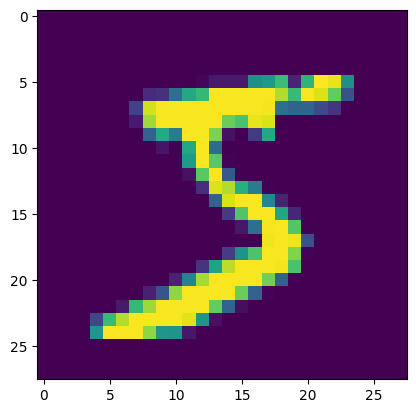

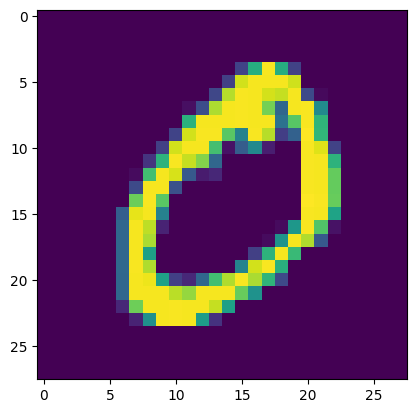

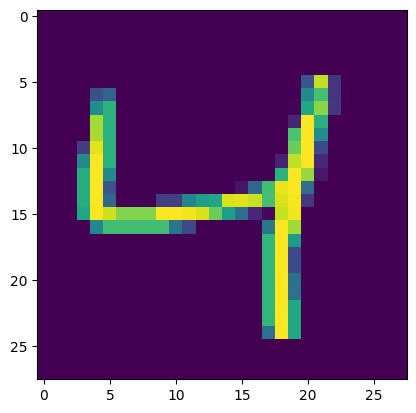

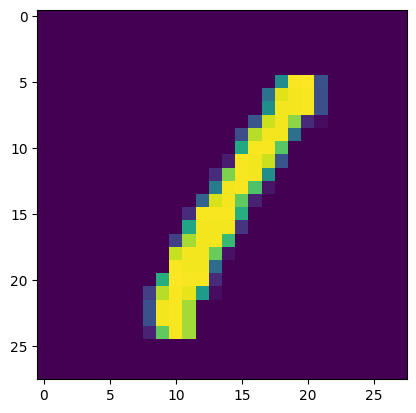

In [4]:
all_images = []
all_indices = []

for i, (images, labels) in enumerate(trainloader):
    all_images.extend(images)
    all_indices.extend(range(i * len(images), (i + 1) * len(images)))

# Convert the list to a NumPy array
all_images = torch.stack(all_images)
all_indices = torch.tensor(all_indices)



# Function to display an image given its index
def imshow_by_index(index):
    img = all_images[index] / 2 + 0.5  # Unnormalize
    plt.imshow(img.permute(1, 2, 0))  # Convert from Tensor image
    plt.show()

# Example: Display the first four images
for i in range(4):
    imshow_by_index(i)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrainableNode(nn.Module):
    def __init__(self, input_features, output_features):
        super(TrainableNode, self).__init__()
        self.linear = nn.Linear(input_features, output_features)
    
    def forward(self, x):
        return self.linear(x)

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Assuming MNIST images are 1x28x28 (channels x width x height)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) # Output: 64x14x14
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x7x7 after pooling
        
        # Flatten: 64*7*7 = 3136 features
        self.fc1 = nn.Linear(3136, 128) # Fully connected layer
        
        # Trainable node for explainability, assuming it requires a flattened input
        self.explainable_node = TrainableNode(128, 1)
        
        self.fc2 = nn.Linear(128, 64) # Additional fully connected layer
        self.fc3 = nn.Linear(64, 10) # Final layer for classifying into 10 classes
        
    def forward(self, x, return_explainable=False):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        x1 = F.relu(self.fc1(x))
        
        if return_explainable:
            explainable_output = self.explainable_node(x1).squeeze()
        
        x = F.relu(self.fc2(x1))
        x = self.fc3(x)
        
        if return_explainable:
            return x, explainable_output
        return x


In [6]:
import torch.optim as optim

# Instantiate the model and move it to the GPU if available
model = MNISTNet().to(device)

# Set the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer (e.g., Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print('[Epoch: %d, Batch: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')


In [8]:
def test_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


In [ ]:
# Train the model
train_model(model, trainloader, criterion, optimizer, num_epochs=10)

# Test the model
test_model(model, testloader)


[Epoch: 1, Batch:   100] loss: 0.915
[Epoch: 1, Batch:   200] loss: 0.234
[Epoch: 1, Batch:   300] loss: 0.212
[Epoch: 1, Batch:   400] loss: 0.127
[Epoch: 1, Batch:   500] loss: 0.130
[Epoch: 1, Batch:   600] loss: 0.097
[Epoch: 1, Batch:   700] loss: 0.083
[Epoch: 1, Batch:   800] loss: 0.079
[Epoch: 1, Batch:   900] loss: 0.088
[Epoch: 1, Batch:  1000] loss: 0.083
[Epoch: 1, Batch:  1100] loss: 0.075
[Epoch: 1, Batch:  1200] loss: 0.082
[Epoch: 1, Batch:  1300] loss: 0.082
[Epoch: 1, Batch:  1400] loss: 0.074
[Epoch: 1, Batch:  1500] loss: 0.078
[Epoch: 1, Batch:  1600] loss: 0.080
[Epoch: 1, Batch:  1700] loss: 0.068
[Epoch: 1, Batch:  1800] loss: 0.057
[Epoch: 2, Batch:   100] loss: 0.068
[Epoch: 2, Batch:   200] loss: 0.055
[Epoch: 2, Batch:   300] loss: 0.061
[Epoch: 2, Batch:   400] loss: 0.052
[Epoch: 2, Batch:   500] loss: 0.051
[Epoch: 2, Batch:   600] loss: 0.052
[Epoch: 2, Batch:   700] loss: 0.035
[Epoch: 2, Batch:   800] loss: 0.039
[Epoch: 2, Batch:   900] loss: 0.054
[